In [1]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
import re
import numpy as np
from nltk.corpus import stopwords
import nltk
from razdel import tokenize
import pymorphy2 
from gensim.models import LdaModel
from gensim.test.utils import datapath

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#nltk.download('stopwords')

In [3]:
class DataPreprocessor:
    def __init__(self, language='russian'):
        self.stopwords = stopwords.words(language)
        self.morph = pymorphy2.MorphAnalyzer()
        self.cache = {}
        
    def clean_text(self, text):
        if not isinstance(text, str):
            text = str(text)
        text = text.lower()
        text = text.strip('\n').strip('\r').strip('\t')
        text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))
        text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
        text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
        text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
        return text

    def lemmatization(self, text):
        if not isinstance(text, str):
            text = str(text)
        tokens = list(tokenize(text))
        words = [_.text for _ in tokens]
        words_lem = []
        for w in words:
            if w[0] == '-':
                w = w[1:]
            if len(w)>1:
                if w in self.cache:
                    words_lem.append(self.cache[w])
                else:
                    temp_cach = self.cache[w] = self.morph.parse(w)[0].normal_form
                    words_lem.append(temp_cach)
        words_lem_without_stopwords=[i for i in words_lem if not i in self.stopwords]
        return words_lem_without_stopwords
    
    def preprocess(self, data, selector):
        data[selector] = data[selector].apply(lambda x: self.clean_text(x), 1)
        data[selector] = data[selector].apply(lambda x: self.lemmatization(x), 1)

In [4]:
class TopicModeler:
    def __init__(self, num_topics, embedding_function):
        self.model = None
        self.num_topics = num_topics
        self.doc_topics = None
        self.common_dictionary = None
        self.embedding_function = embedding_function
        
    def fit(self, data, selector, random_state=42):
        texts = [t for t in data[selector].values]
        self.common_dictionary = Dictionary(texts)
        common_corpus = [self.common_dictionary.doc2bow(text) for text in texts]
        self.model = LdaModel(common_corpus, num_topics=self.num_topics, id2word=self.common_dictionary, random_state=random_state)
    
    def show_topics(self, num_words=8):
        x = self.model.show_topics(num_topics=self.num_topics, num_words=num_words, formatted=False)
        topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
        for topic, words in topics_words:
            print(f"topic_{topic}: {' '.join(words)}")
            
    def _get_lda_vector(self, text):
        unseen_doc = self.common_dictionary.doc2bow(text)
        lda_tuple = self.model[unseen_doc]
        not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))
        output_vector = []
        for i in range(self.num_topics):
            if i not in not_null_topics:
                output_vector.append(0)
            else:
                output_vector.append(not_null_topics[i])
        return np.array(output_vector)
    
    def calc_topic_matrix(self, data, id_selector, data_selector):
        topic_matrix = pd.DataFrame([self._get_lda_vector(text) for text in news[data_selector].values])
        topic_matrix.columns = [f'topic_{i}'for i in range(self.num_topics)]
        topic_matrix[id_selector] = data[id_selector].values
        topic_matrix = topic_matrix[[id_selector]+[f'topic_{i}'for i in range(self.num_topics)]]
        self.doc_topics = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(self.num_topics)]].values))
        return topic_matrix
    
    def _get_user_embedding(self, user_articles_list):
        user_articles_list = eval(user_articles_list)
        user_vector = np.array([self.doc_topics[doc_id] for doc_id in user_articles_list])
        user_vector = self.embedding_function(user_vector, 0)
        return user_vector
    
    def get_user_embeddings(self, users_articles_data, id_selector, articles_selector):
        user_embeddings = pd.DataFrame([i for i in users_articles_data[articles_selector].apply(lambda x: self._get_user_embedding(x), 1)])
        user_embeddings.columns = [f'topic_{i}' for i in range(self.num_topics)]
        user_embeddings[id_selector] = users[id_selector].values
        user_embeddings = user_embeddings[[id_selector]+[f'topic_{i}' for i in range(self.num_topics)]]
        return user_embeddings

In [5]:
def get_topic_embeddings(news, users, target_path, num_topics, embedding_function=np.mean):
    topic_model = TopicModeler(num_topics, embedding_function)
    topic_model.fit(news, 'title')
    topic_model.calc_topic_matrix(news, 'doc_id', 'title')
    user_embeddings = topic_model.get_user_embeddings(users, 'uid', 'articles')
    
    target = pd.read_csv(target_path)
    X = pd.merge(user_embeddings, target, 'left')
    return topic_model, X

def plot_confusion_matrix(cm, classes,  normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    font = {'size' : 10}
    plt.rc('font', **font)
    plt.figure(figsize=(5, 4))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("conf_matrix.png")
    plt.show()

In [6]:
def run(news, users, num_topics, embedding_function):
    topic_model, X = get_topic_embeddings(news, users, "users_churn.csv", num_topics=num_topics, embedding_function=embedding_function)
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(num_topics)]], 
                                                        X['churn'], random_state=0)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    preds = logreg.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))

    roc_auc = roc_auc_score(y_test, preds)
    print(f'ROC_AUC: {roc_auc}')
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'], title='Confusion matrix')
    return roc_auc, fscore[ix], precision[ix], recall[ix]

In [7]:
news = pd.read_csv("articles.csv")
users = pd.read_csv("users_articles.csv")

In [8]:
%%time
preprocessor = DataPreprocessor()
preprocessor.preprocess(news, 'title')

<ipython-input-3-1f58c1ad8ba3>:13: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 2min 50s


In [9]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

Best Threshold=0.247035, F-Score=0.672, Precision=0.625, Recall=0.727
ROC_AUC: 0.944417698703413
Confusion matrix, without normalization
[[1648  107]
 [  68  177]]


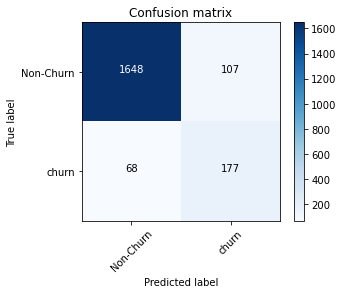

In [10]:
mean_metrics = run(news, users, num_topics=25, embedding_function=np.mean)

2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

Best Threshold=0.281805, F-Score=0.671, Precision=0.660, Recall=0.682
ROC_AUC: 0.9439455782312924
Confusion matrix, without normalization
[[1669   86]
 [  79  166]]


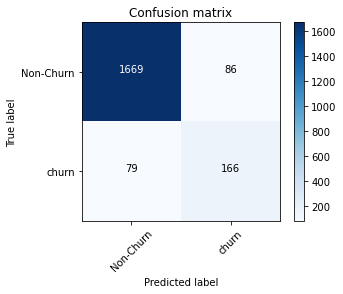

In [11]:
median_metrics = run(news, users, num_topics=25, embedding_function=np.median)

3. Повторить п.2, но используя уже не медиану, а max

Best Threshold=0.330245, F-Score=0.824, Precision=0.816, Recall=0.833
ROC_AUC: 0.9760381417524274
Confusion matrix, without normalization
[[1709   46]
 [  42  203]]


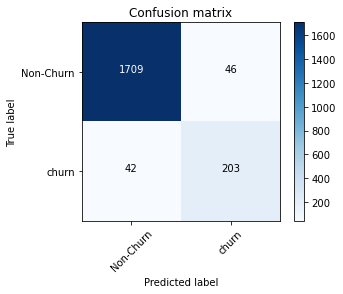

In [12]:
max_metrics = run(news, users, num_topics=25, embedding_function=np.max)

4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [15]:
cleaned_arcicles = []
for article in users['articles'].values:
    cleaned_arcicles.append(re.sub(r"[\[\],]", '', article))
vectorizer = TfidfVectorizer()
sparce_matrix = vectorizer.fit_transform(pd.DataFrame(cleaned_arcicles)[0])

In [16]:
idf = vectorizer.idf_
idf_dict = dict(zip(vectorizer.get_feature_names(), idf))
X = pd.DataFrame([[user] + eval(articles) for user, articles in zip(users['uid'],users['articles'])])
idf_rows = []
for row in X.iterrows():
    idf_rows.append([row[1][0]] + [idf_dict.get(str(row[1][i]),0) for i in range(1, 7)])
X = pd.DataFrame(idf_rows)
X.rename(columns={0: 'uid'}, inplace=True)

In [17]:
target = pd.read_csv("users_churn.csv")
X = pd.merge(X, target, 'left')

In [18]:
X

,uid,1,2,3,4,5,6,churn
0,u105138,8.601027,8.377884,8.601027,9.294175,8.195562,8.601027,0
1,u108690,8.601027,8.888710,9.294175,8.195562,8.888710,7.790097,1
2,u108339,8.195562,9.294175,8.377884,8.601027,8.377884,7.790097,1
3,u101138,8.377884,8.195562,8.888710,8.601027,8.195562,8.377884,0
4,u108248,8.377884,8.041412,8.601027,8.195562,8.377884,8.041412,1
...,...,...,...,...,...,...,...,...
7995,u107463,7.589427,8.377884,7.502415,8.377884,7.907880,9.294175,0
7996,u101241,7.907880,8.601027,8.601027,8.195562,8.601027,9.294175,0
7997,u106486,8.041412,7.502415,7.279272,7.907880,7.907880,8.377884,0
7998,u102220,7.790097,8.377884,8.377884,8.195562,8.377884,9.294175,0


Best Threshold=0.359563, F-Score=0.866, Precision=0.839, Recall=0.894
ROC_AUC: 0.9892005349148206
Confusion matrix, without normalization
[[1713   42]
 [  27  218]]


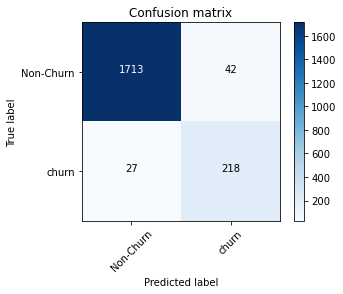

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X[[i for i in range(1, 7)]], 
                                                        X['churn'], random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

roc_auc = roc_auc_score(y_test, preds)
print(f'ROC_AUC: {roc_auc}')
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'], title='Confusion matrix')
tfidf_metrics = roc_auc, fscore[ix], precision[ix], recall[ix]

6. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score.
Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [28]:
pd.DataFrame([('mean',*mean_metrics), ('median',*median_metrics), ('max',*max_metrics), ('tfidf',*tfidf_metrics)], columns=['name', 'roc_auc', 'f1_score', 'precision', 'recall'])

,name,roc_auc,f1_score,precision,recall
0,mean,0.944418,0.671698,0.624561,0.726531
1,median,0.943946,0.670683,0.660079,0.681633
2,max,0.976038,0.824242,0.816000,0.832653
3,tfidf,0.989201,0.865613,0.839080,0.893878


В данной задаче, при применении тематического моделирования лучше всего показывает себя функция max при построении вектора признаков пользователей. Решение задачи при применении tfidf векторизации дает самый лучший результат.
Возможно в задаче определения оттока пользователей чтение определенных статей влияет сильнее чем их тематика